In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import multiclass_helper as MH
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


# Generamos Dataset

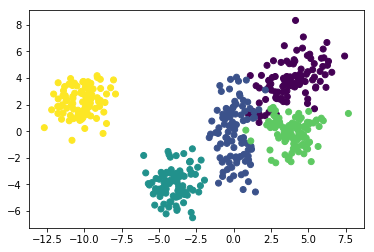

In [51]:
N = 100
mu_1 = [4, 4]
sigma_1 = [[  2,0.8],
           [0.8,  2]]

mu_2 = [0, 0]
sigma_2 = [[  0.5,  0],
           [  0,  4]]

mu_3 = [-4, -4]
sigma_3 = [[  1,  0],
           [  0,  1]]

mu_4 = [4, 0]
sigma_4 = [[  1,  0],
           [  0,  1]]

mu_5 = [-10, 2]
sigma_5 = [[  1,  0],
           [  0,  1]]


rvs = [
        [mu_1, sigma_1, N], 
        [mu_2, sigma_2, N],
        [mu_3, sigma_3, N],
        [mu_4, sigma_4, N],
        [mu_5, sigma_5, N]
      ]

X, y = MH.generate_dataset(rvs)
y_cat = to_categorical(y)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

# Dividimos en train y test set

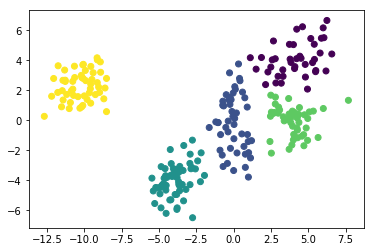

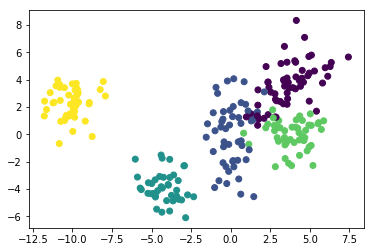

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.show()
plt.scatter(X_test[:,0], X_test[:,1], c=y_test)
plt.show()

In [53]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation
from helper import PlotLosses
from keras.callbacks import ModelCheckpoint
from keras.initializers import RandomNormal
from keras import regularizers

In [54]:
#np.save('X_train_5_clases_1', X_train)
#np.save('X_test_5_clases_1', X_test)
#np.save('y_train_5_clases_1', y_train)
#np.save('y_test_5_clases_1', y_test)

# One vs Rest

Entrenamos tantos modelos de regresión logística como clases tengo. Se calcula una solución de la clase contra todo el resto de las clases

## Regresión Logística

### Definimos un modelo para cada clase

In [55]:
input_features = 2
lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 200
#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

models_vs_rest = []
for i in range(y_train_cat.shape[1]):
    plot_losses = PlotLosses(plot_interval=50, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat[:,i])
    model_vs_rest = Sequential()
    model_vs_rest.add(Dense(1,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
    model_vs_rest.add(Activation('sigmoid', name="sigmoid"))
    model_vs_rest.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])
    models_vs_rest.append(model_vs_rest)

### Entrenamos cada modelo por separado
La función de costo es simplemente la entropia binaria para cada clase

$J = y log(\hat{y}) + (1-y) log(1-\hat{y})$  

donde $y$ es 1 si pertenece a una de las clases, y 0 si pertenece a la otra clase  

$\hat{y} = w_0 + w_1 X_0 + w_2 X_1 $

$X_i$'s son los features

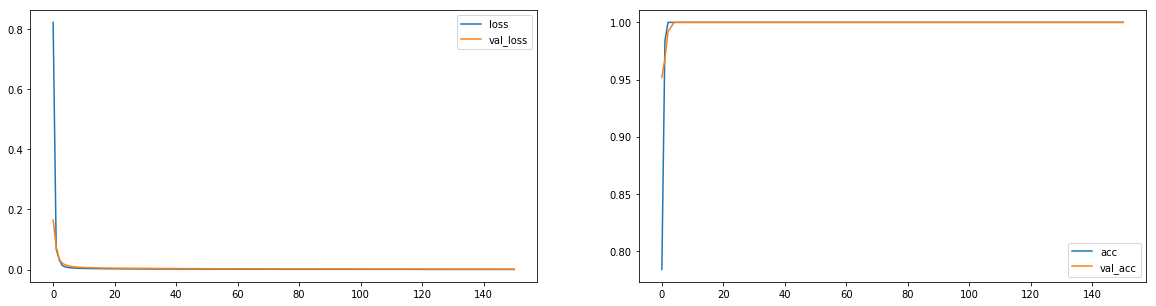

In [56]:
for i in range(y_test_cat.shape[1]):
    models_vs_rest[i].fit(X_train, 
              y_train_cat[:,i], 
              batch_size = batch_size,
              epochs=epochs, 
              verbose=0, 
              validation_data=(X_test, y_test_cat[:,i]), 
              callbacks=[plot_losses],
             )

In [114]:
def predict_proba_one_rest(X, verbose=1):
    proba = np.array([]).reshape(X.shape[0], 0)
    for model in models_vs_rest:
        out = model.predict_proba(X, verbose=verbose)
        proba = np.hstack([proba, out])
    return proba

def evaluate_proba_one_rest(X, y):
    return np.sum(np.argmax(predict_proba_one_rest(X), axis = 1) == y)/len(y)

Cada modelo da una solución lineal (recta).  
El modelo 2 no se ve la recta pero esta en algún lugar por abajo.  
Lo que indica es que todos los puntos perteneces al resto, por eso da 80% = (tot - cant en clase)/tot  
**Notar que para 5 clases, si la recta no incluye ningun punto, el accuracy es del 80% **

En general si C es la cantidad de clases, y todas las clases tienen la misma cantidad de puntos, el accuracy será:  
1-1/C

### Graficamos cada modelo

89600/90000 [============================>.] - ETA: 0s

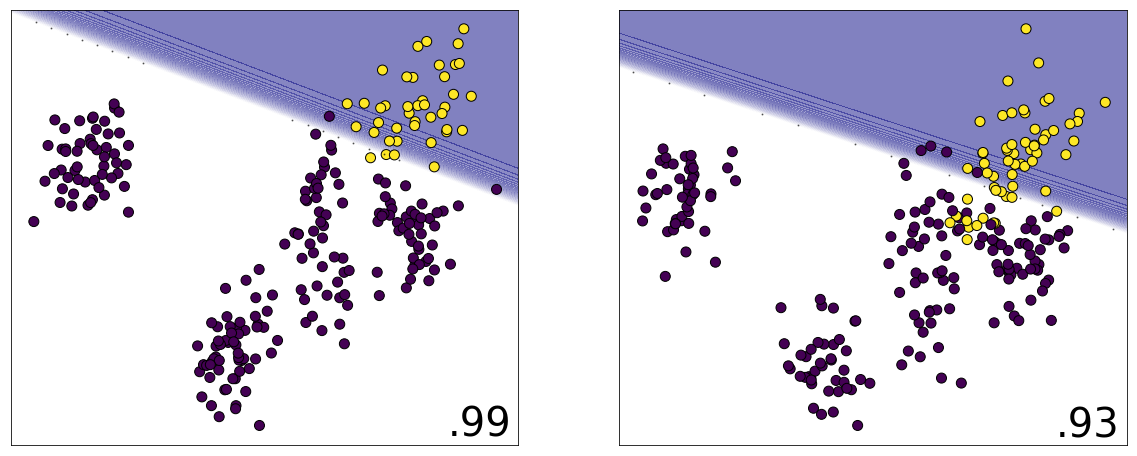

89280/90000 [============================>.] - ETA: 0s

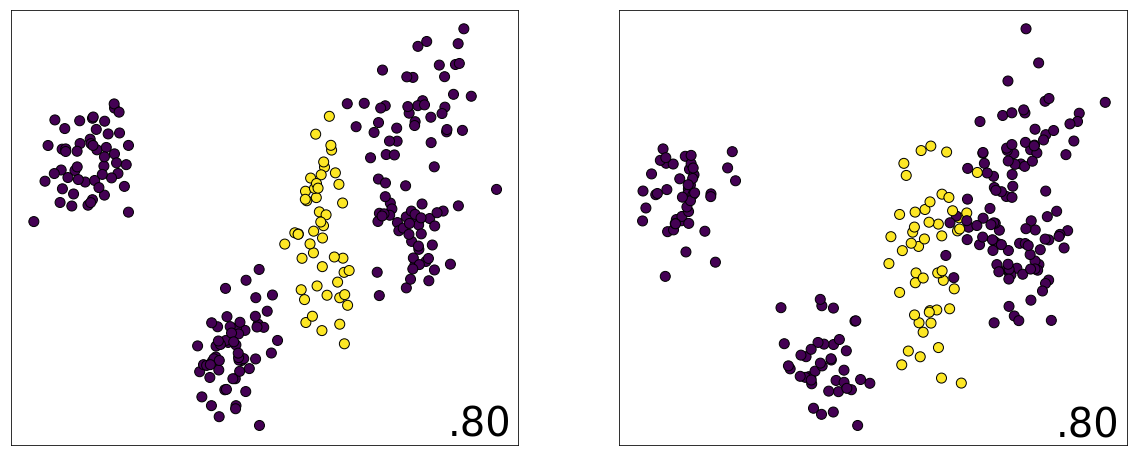

89600/90000 [============================>.] - ETA: 0s

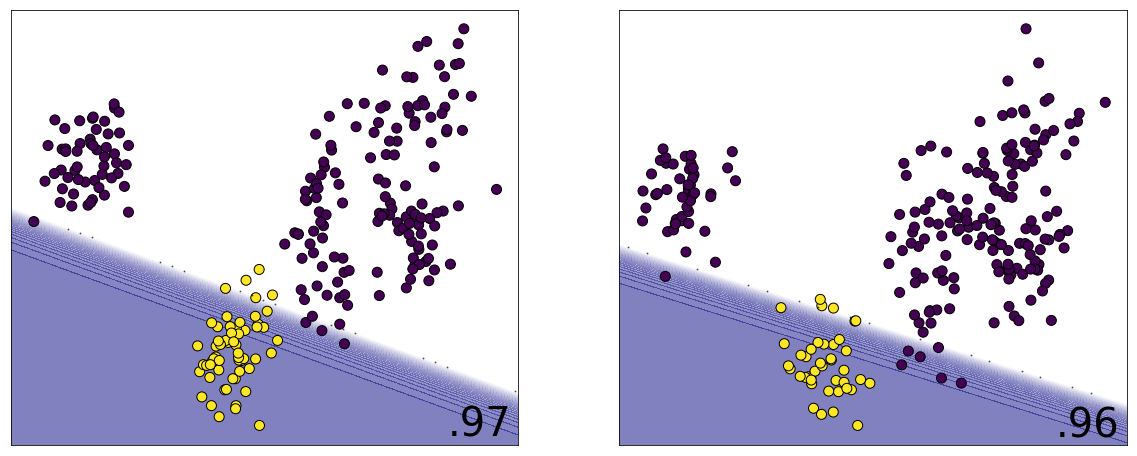

89248/90000 [============================>.] - ETA: 0s

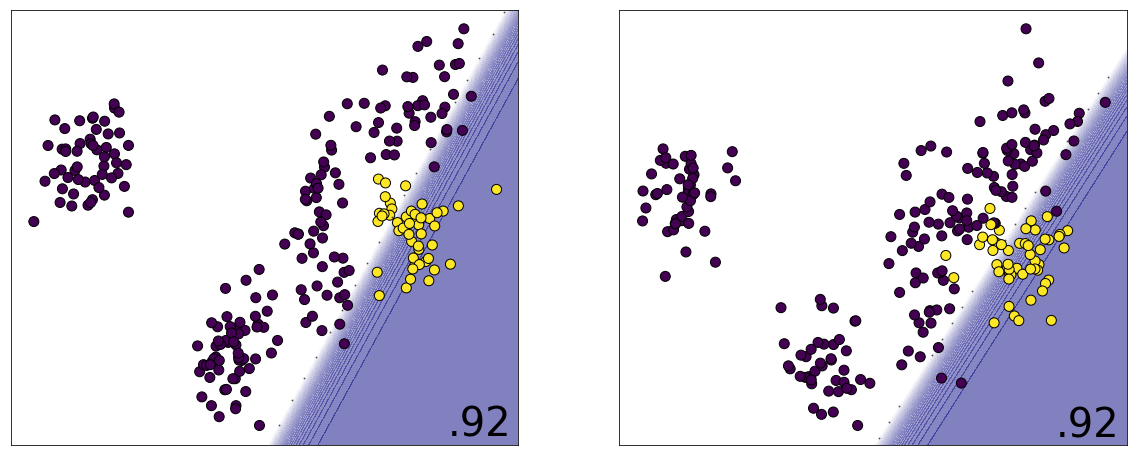

89568/90000 [============================>.] - ETA: 0s

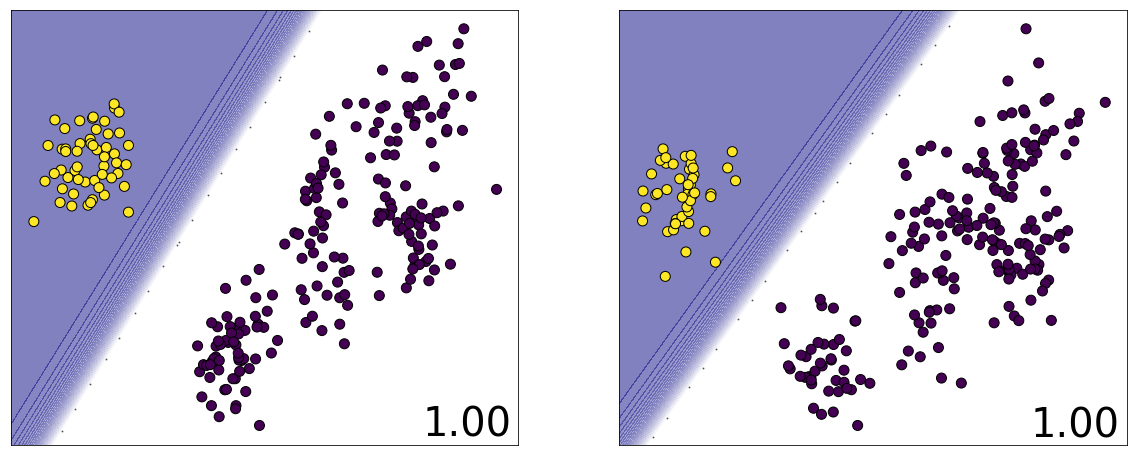

In [98]:
for rv_sel in range(y_train_cat.shape[1]):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    score_train = models_vs_rest[rv_sel].evaluate(X_train, y_train_cat[:,rv_sel])[1]
    score_test = models_vs_rest[rv_sel].evaluate(X_test, y_test_cat[:,rv_sel])[1]
    MH.plot_MC_boundaries_keras(X_train, y_train_cat[:,rv_sel], score_train, models_vs_rest[rv_sel].predict_proba, normalize = False, h =.05, ax=ax1)
    MH.plot_MC_boundaries_keras(X_test, y_test_cat[:,rv_sel], score_test, models_vs_rest[rv_sel].predict_proba, normalize = False, h =.05, ax=ax2)
    plt.show()

- Recordar que el umbral es donde la probabilidad es 0.5.
- De la recta para un lado es mas probable que sea la clase analizada que alguna del resto de las clases, y viceverza

### Superponemos todas las soluciones

89952/90000 [============================>.] - ETA: 0s

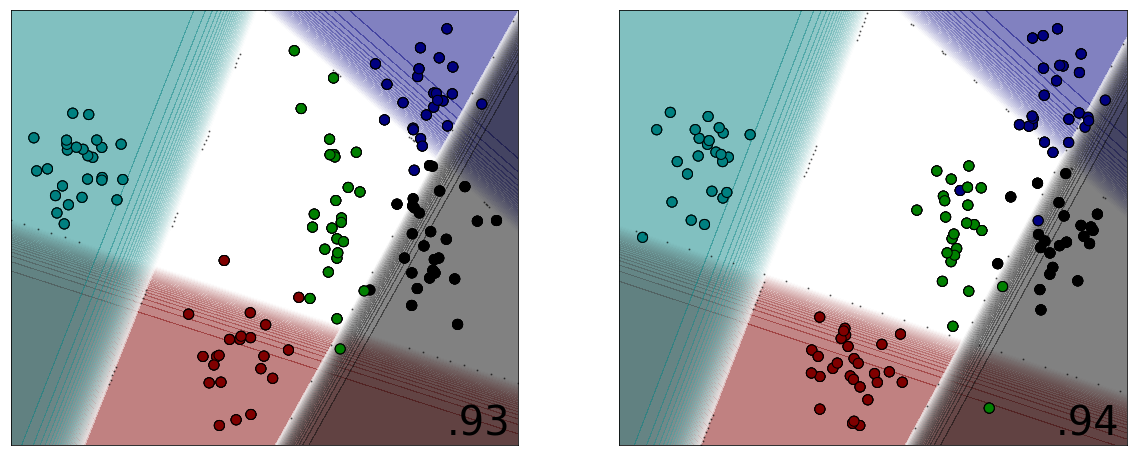

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest, normalize = False, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest, normalize = False, h =.05, ax=ax2)
plt.show()

In [117]:
# Esta función calcula la P contra cada modelo y la devuleve como vector
print(np.round(predict_proba_one_rest(X_train, verbose=0)[:5]*100)/100)

[[ 0.    0.07  0.    0.    1.  ]
 [ 0.    0.17  0.52  0.    0.  ]
 [ 0.    0.07  0.01  0.    1.  ]
 [ 0.    0.24  0.    0.11  0.  ]
 [ 0.    0.17  1.    0.    0.  ]]


In [118]:
# Verificamos que no suman 1 como es de esperar
print(predict_proba_one_rest(X_train, verbose=0)[:5].sum(axis=1))

[ 1.07280256  0.69114095  1.08084827  0.35104472  1.17655346]


### Graficamos pero normalizando

89472/90000 [============================>.] - ETA: 0s

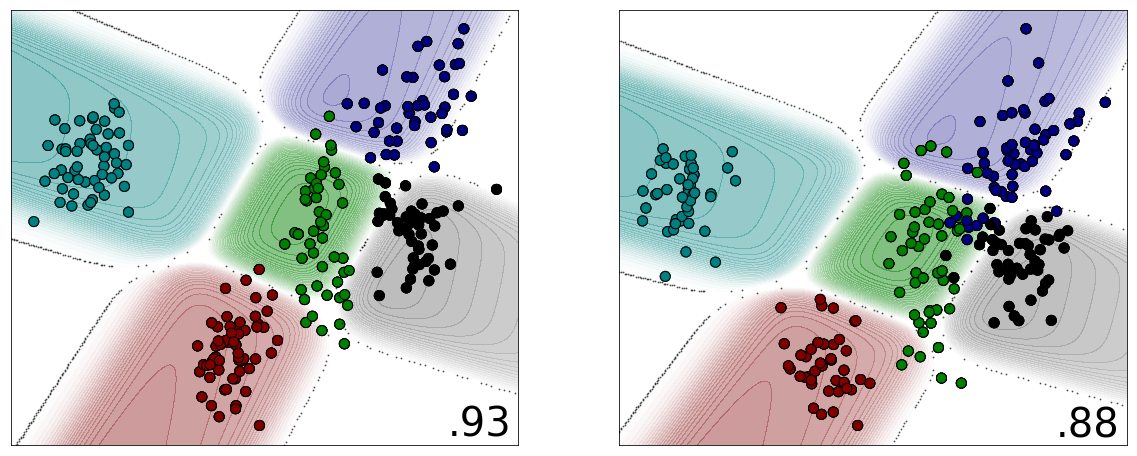

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest, normalize = True, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest, normalize = True, h =.05, ax=ax2)
plt.show()

- Notar que zonas que estaban en blanco por que la probabilidad era menor a 0.5 para todos los modelos, ahora ya no estan en blanco.
- En el centro aparece la Clase 2 por que su pendiente era muy chica y entonces ahora es el maximo
- Las zonas en blanco que quedan se deben a que la probabilidad de ninguna de las clases es mayor a 0.5

### Ejemplo de "zonas en blanco"

In [135]:
X1 = -12
X2 = -3
point = np.array([X1, X2]).reshape(1,2)
predicted = predict_proba_one_rest(point, verbose=0)
print(np.round(predicted*100)/100)
print('Normalizando:')
suma = predicted.sum()
print(np.round(predicted/suma*100)/100)

[[ 0.    0.07  1.    0.    1.  ]]
Normalizando:
[[ 0.    0.03  0.48  0.    0.48]]


In [157]:
def predict_class_one_rest(X):
    return to_categorical(np.argmax(predict_proba_one_rest(X), axis=1))

89824/90000 [============================>.] - ETA: 0s

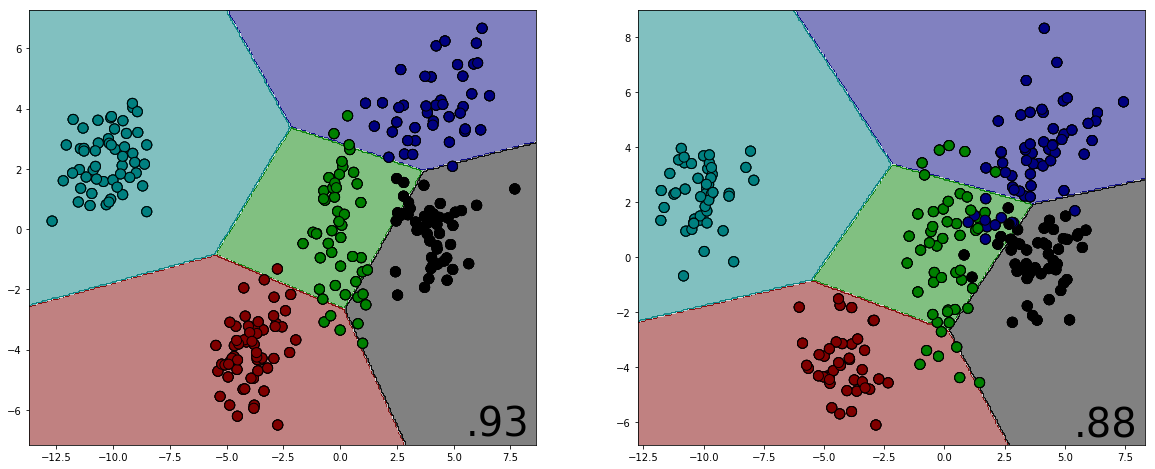

In [159]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest(X_train, y_train)
score_test = evaluate_proba_one_rest(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_class_one_rest, normalize = False, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_class_one_rest, normalize = False, h =.05, ax=ax2)
plt.show()

## Red Neuronal

In [77]:
input_features = 2
hidden_units = 2
lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 500
#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

models_vs_rest_nn = []
for i in range(y_train_cat.shape[1]):
    plot_losses = PlotLosses(plot_interval=50, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat[:,i])
    model_vs_rest_nn = Sequential()
    model_vs_rest_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
    model_vs_rest_nn.add(Activation('sigmoid', name="sigmoid"))
    model_vs_rest_nn.add(Dense(1, kernel_regularizer=regularizers.l2(lambd)))
    model_vs_rest_nn.add(Activation('sigmoid'))
    model_vs_rest_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])
    models_vs_rest_nn.append(model_vs_rest_nn)

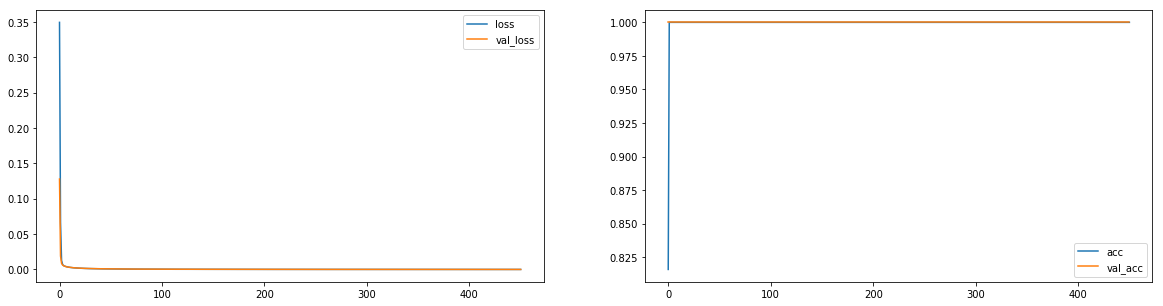

In [78]:
for i in range(y_test_cat.shape[1]):
    models_vs_rest_nn[i].fit(X_train, 
              y_train_cat[:,i], 
              batch_size = batch_size,
              epochs=epochs, 
              verbose=0, 
              validation_data=(X_test, y_test_cat[:,i]), 
              callbacks=[plot_losses],
             )

89184/90000 [============================>.] - ETA: 0s

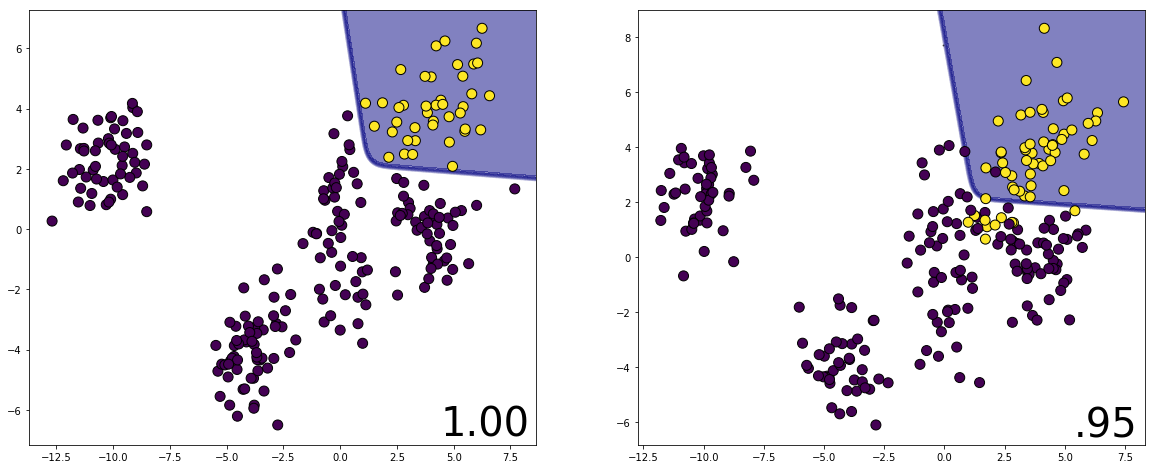

88928/90000 [============================>.] - ETA: 0s

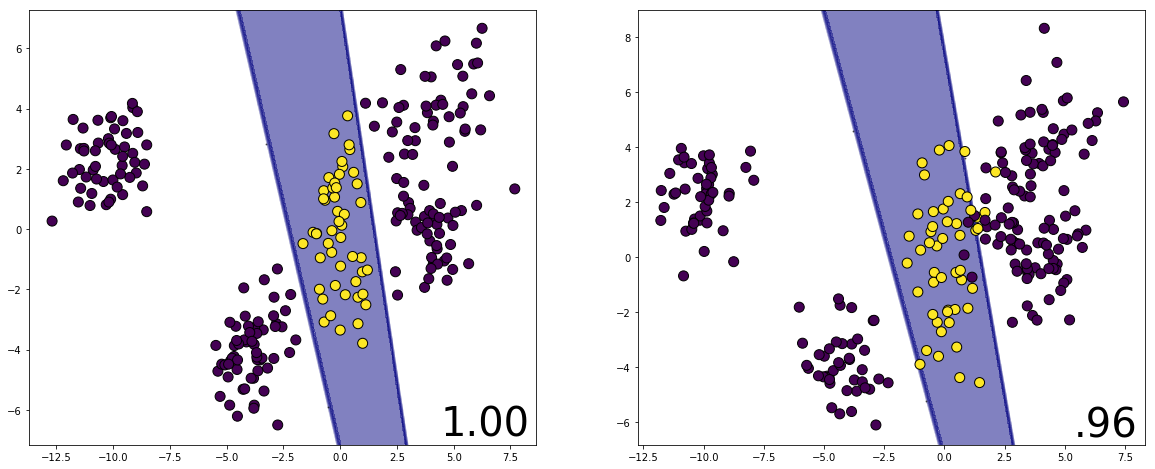

89952/90000 [============================>.] - ETA: 0s

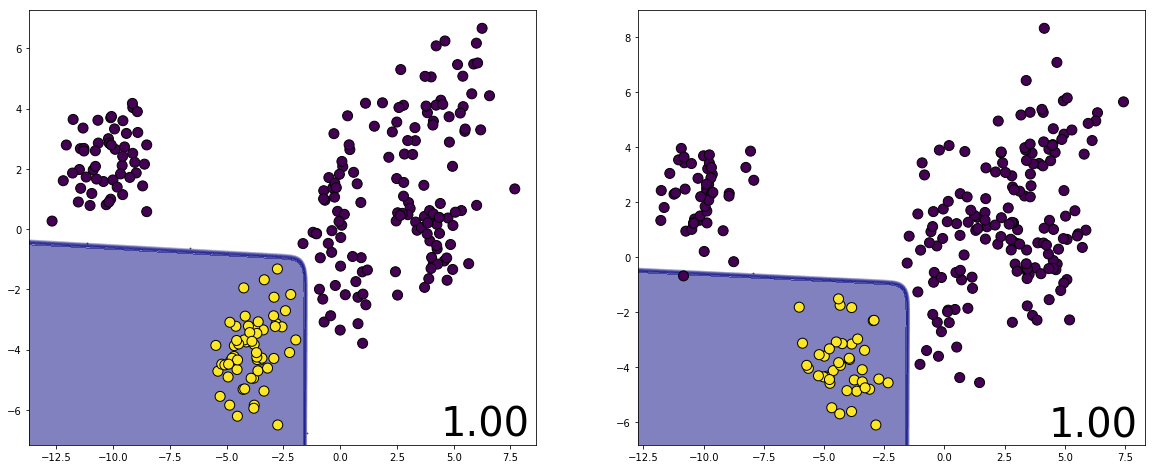

89056/90000 [============================>.] - ETA: 0s

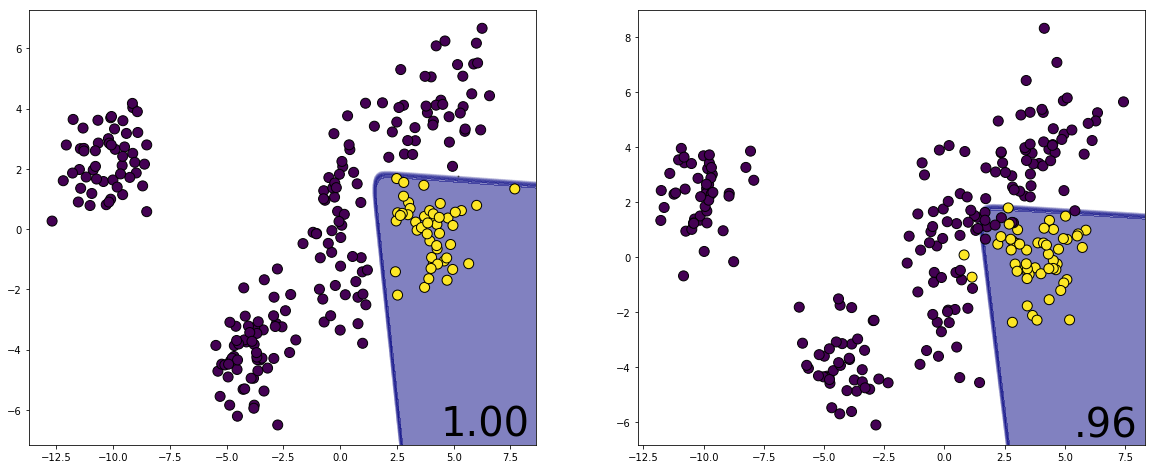

89536/90000 [============================>.] - ETA: 0s

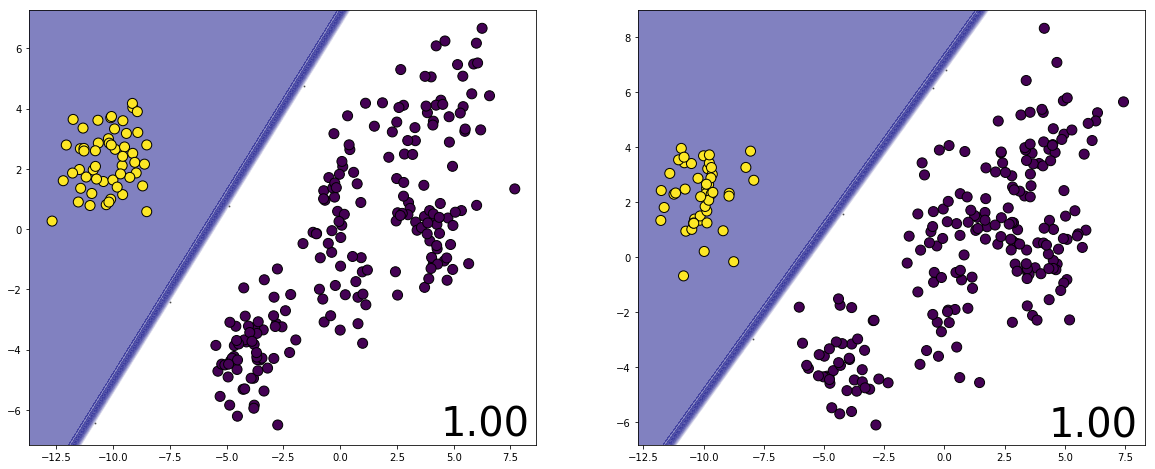

In [163]:
for rv_sel in range(y_train_cat.shape[1]):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    score_train = models_vs_rest_nn[rv_sel].evaluate(X_train, y_train_cat[:,rv_sel])[1]
    score_test = models_vs_rest_nn[rv_sel].evaluate(X_test, y_test_cat[:,rv_sel])[1]
    MH.plot_MC_boundaries_keras(X_train, y_train_cat[:,rv_sel], score_train, models_vs_rest_nn[rv_sel].predict_proba, normalize = False, h =.05, ax=ax1)
    MH.plot_MC_boundaries_keras(X_test, y_test_cat[:,rv_sel], score_test, models_vs_rest_nn[rv_sel].predict_proba, normalize = False, h =.05, ax=ax2)
    plt.show()

In [136]:
def predict_proba_one_rest_nn(X, verbose=1):
    proba = np.array([]).reshape(X.shape[0], 0)
    for model in models_vs_rest_nn:
        out = model.predict_proba(X, verbose=verbose)
        proba = np.hstack([proba, out])
    return proba

def evaluate_proba_one_rest_nn(X, y):
    return np.sum(np.argmax(predict_proba_one_rest_nn(X), axis = 1) == y)/len(y)

89088/90000 [============================>.] - ETA: 0s

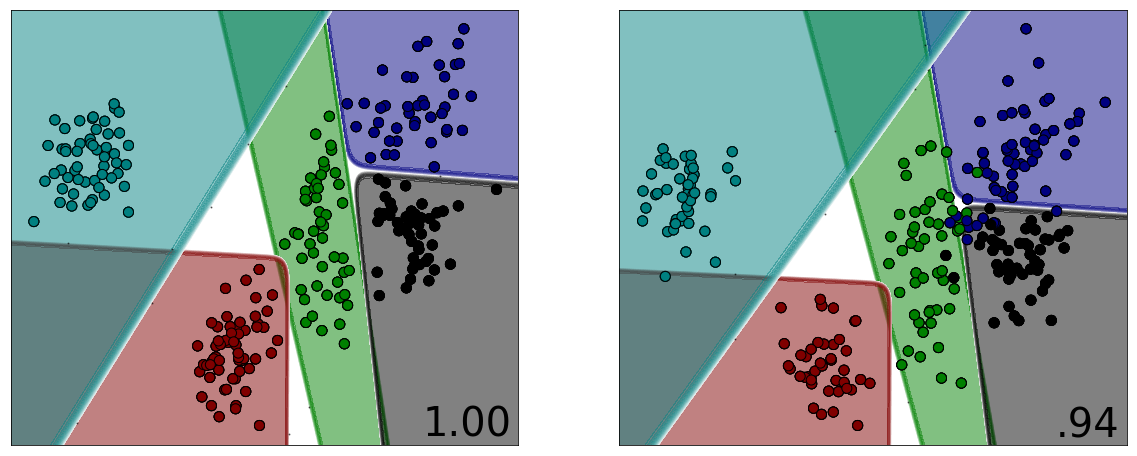

In [94]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest_nn(X_train, y_train)
score_test = evaluate_proba_one_rest_nn(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest_nn, normalize = False, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest_nn, normalize = False, h =.05, ax=ax2)
plt.show()

89504/90000 [============================>.] - ETA: 0s

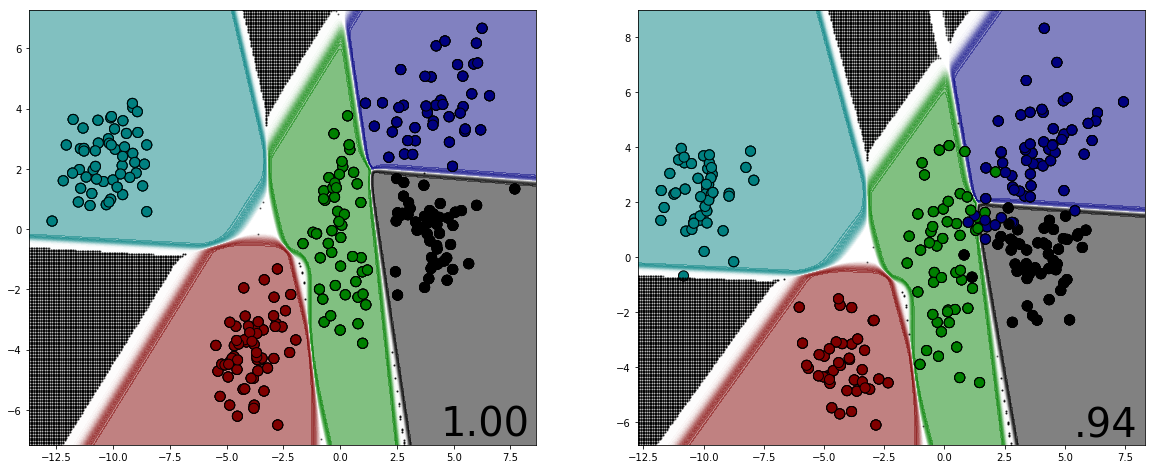

In [149]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest_nn(X_train, y_train)
score_test = evaluate_proba_one_rest_nn(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_proba_one_rest_nn, normalize = True, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_proba_one_rest_nn, normalize = True, h =.05, ax=ax2)
plt.show()

In [148]:
X1 = -2.9
X2 = 0
point = np.array([X1, X2]).reshape(1,2)
predicted = predict_proba_one_rest_nn(point, verbose=0)
print(np.round(predicted*100)/100)
print('Normalizando:')
suma = predicted.sum()
print(np.round(predicted/suma*100)/100)

[[ 0.  0.  0.  0.  0.]]
Normalizando:
[[ 0.    0.32  0.29  0.35  0.04]]


In [160]:
def predict_class_one_rest_nn(X):
    return to_categorical(np.argmax(predict_proba_one_rest_nn(X), axis=1))

89088/90000 [============================>.] - ETA: 0s

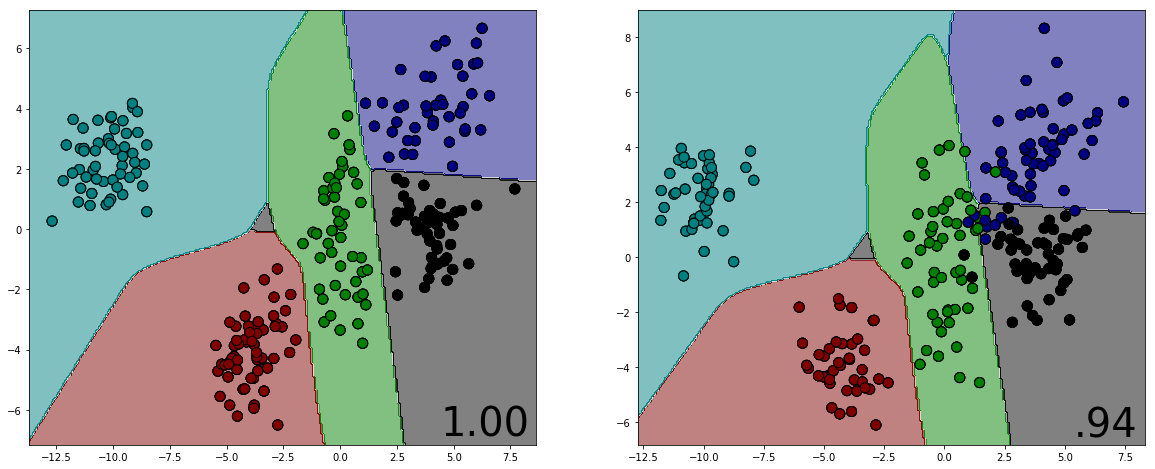

In [161]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = evaluate_proba_one_rest_nn(X_train, y_train)
score_test = evaluate_proba_one_rest_nn(X_test, y_test)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train, predict_class_one_rest_nn, normalize = True, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test, predict_class_one_rest_nn, normalize = True, h =.05, ax=ax2)
plt.show()

# Modelo con C sigmoideas donde C es la cantidad de Clases
## Regresión logistica

In [65]:
output_size = y_train_cat.shape[1]
input_features = 2
lambd = 0 #0.001

model_sig_log = Sequential()
model_sig_log.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_log.add(Activation('sigmoid', name="sigmoid"))
model_sig_log.summary()


lr = 0.04 
batch_size = 20
epochs = 500

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_log.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 5)                 15        
_________________________________________________________________
sigmoid (Activation)         (None, 5)                 0         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


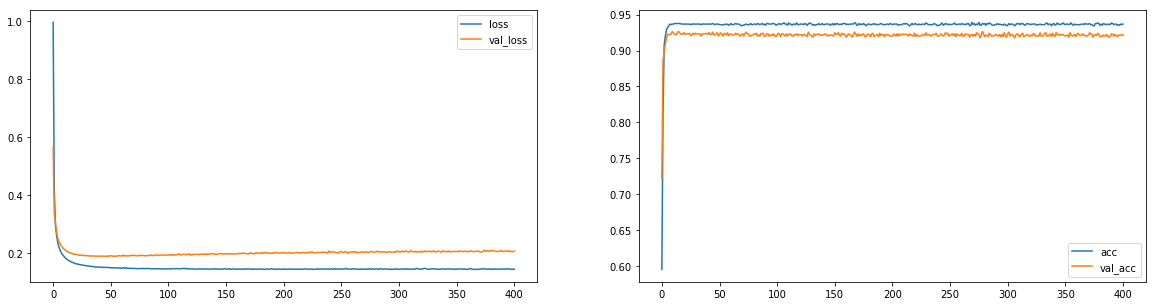

In [66]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sig_log.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

88640/90000 [============================>.] - ETA: 0s

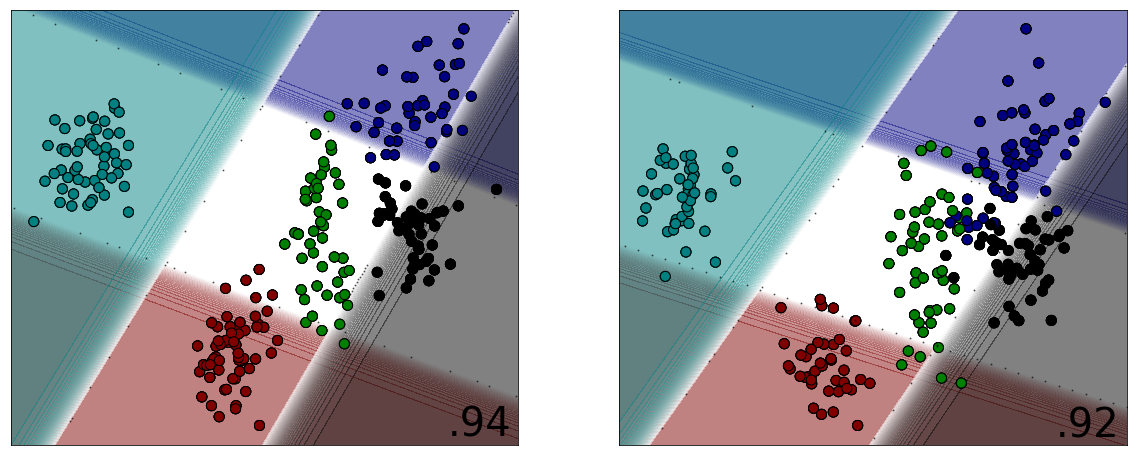

In [95]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_log.evaluate(X_train, y_train_cat)
score_test = model_sig_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_log.predict_proba, normalize = False, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_log.predict_proba, normalize = False, h =.05, ax=ax2)
plt.show()

89248/90000 [============================>.] - ETA: 0s

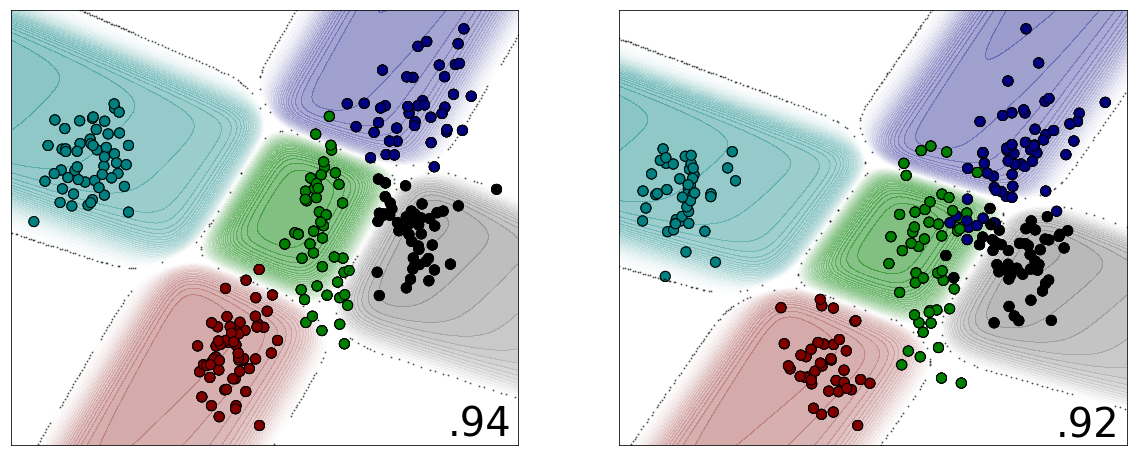

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_log.evaluate(X_train, y_train_cat)
score_test = model_sig_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_log.predict_proba, normalize = True, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_log.predict_proba, normalize = True, h =.05, ax=ax2)
plt.show()

## Red Neuronal de 1 capa oculta

In [74]:
hidden_units = 2
model_sig_nn = Sequential()
model_sig_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sig_nn.add(Activation('sigmoid', name="sigmoid"))
model_sig_nn.add(Dense(output_size, name="Salida"))
model_sig_nn.add(Activation('sigmoid', name="output")) 
model_sig_nn.summary()

lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sig_nn.compile(loss = 'binary_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 2)                 6         
_________________________________________________________________
sigmoid (Activation)         (None, 2)                 0         
_________________________________________________________________
Salida (Dense)               (None, 5)                 15        
_________________________________________________________________
output (Activation)          (None, 5)                 0         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


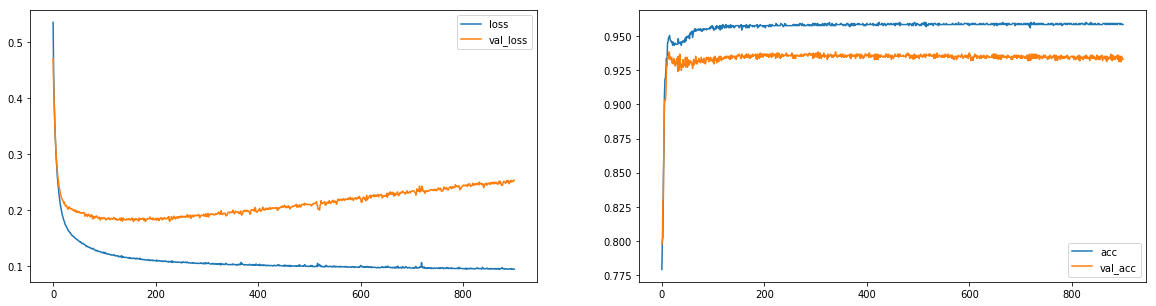

In [75]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sig_nn.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

89376/90000 [============================>.] - ETA: 0s

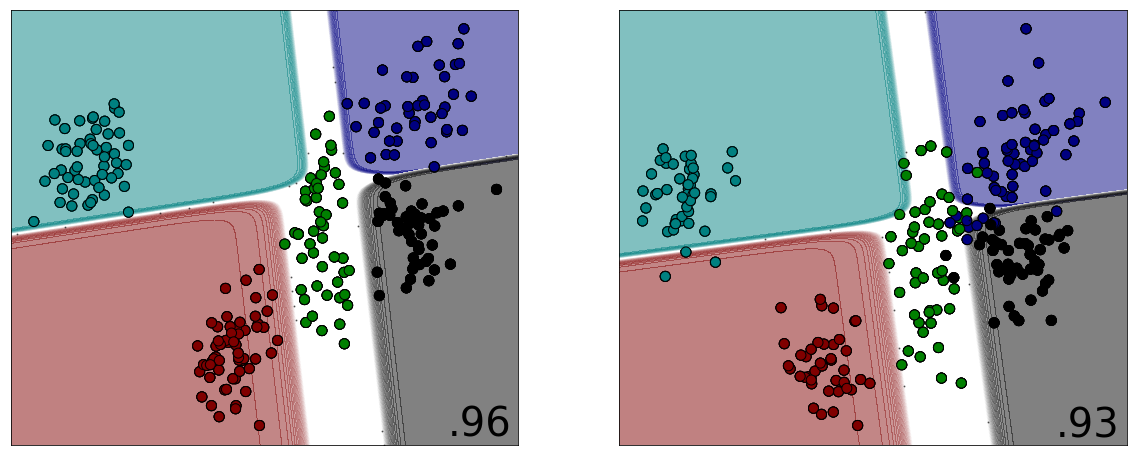

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_nn.evaluate(X_train, y_train_cat)
score_test = model_sig_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_nn.predict_proba, normalize = False, mesh_res = 300, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_nn.predict_proba, normalize = False, mesh_res = 300, ax=ax2)
plt.show()

89248/90000 [============================>.] - ETA: 0s

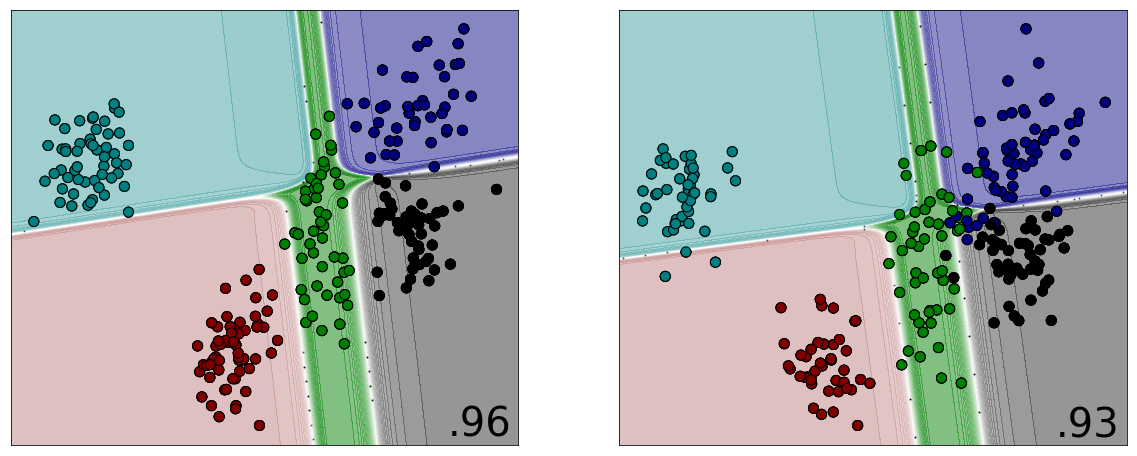

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sig_nn.evaluate(X_train, y_train_cat)
score_test = model_sig_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sig_nn.predict_proba, normalize = True, mesh_res = 300, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sig_nn.predict_proba, normalize = True, mesh_res = 300, ax=ax2)
plt.show()

# Modelo con Softmax

## Regresión logística

In [86]:
input_features = 2
hidden_units = 20
output_size = y_train_cat.shape[1]
model_sm_log = Sequential()
model_sm_log.add(Dense(output_size,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sm_log.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_sm_log.summary()

lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 500

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sm_log.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 5)                 15        
_________________________________________________________________
softmax (Activation)         (None, 5)                 0         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


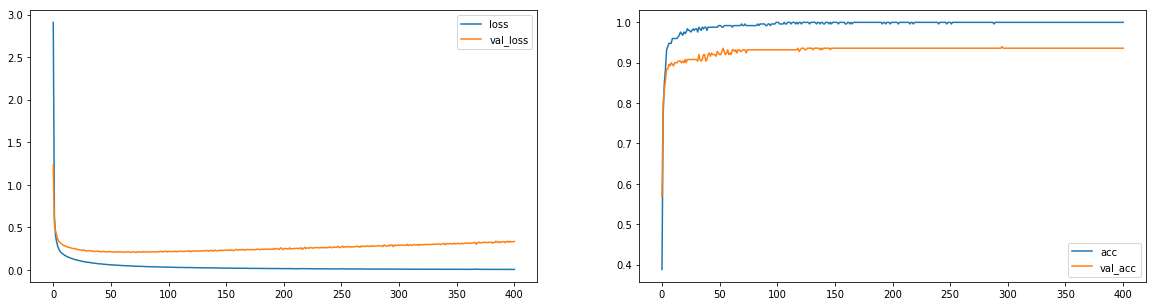

In [87]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sm_log.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

88832/90000 [============================>.] - ETA: 0s

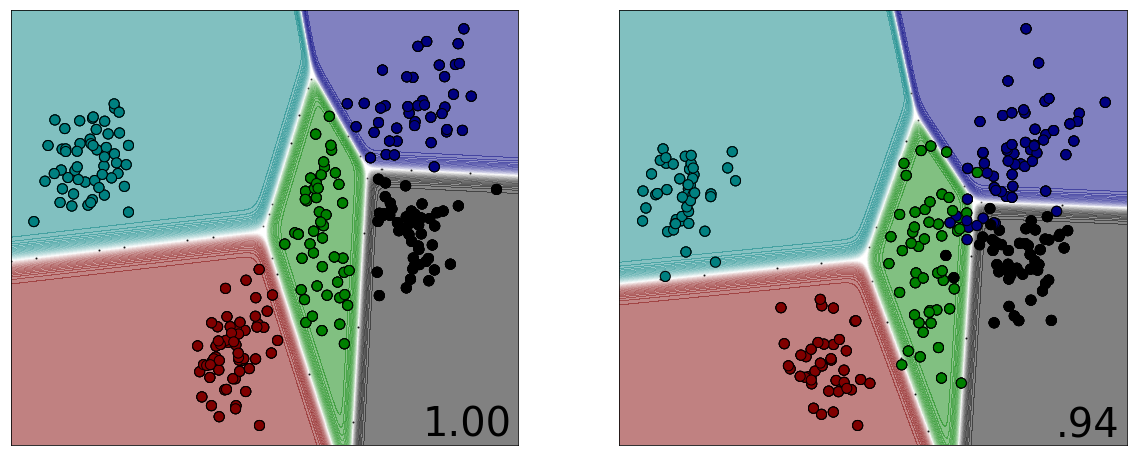

In [88]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sm_log.evaluate(X_train, y_train_cat)
score_test = model_sm_log.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sm_log.predict_proba, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sm_log.predict_proba, h =.05, ax=ax2)
plt.show()

## Red neuronal de 1 capa oculta

In [89]:
input_features = 2
hidden_units = 2
output_size = y_train_cat.shape[1]
model_sm_nn = Sequential()
model_sm_nn.add(Dense(hidden_units,input_dim=input_features, kernel_regularizer=regularizers.l2(lambd), name="Capa_Oculta"))
model_sm_nn.add(Activation('sigmoid', name="sigmoid"))
model_sm_nn.add(Dense(output_size, name="Salida"))
model_sm_nn.add(Activation('softmax', name="softmax")) # Notar que en vez de sigmoidea es softmax
model_sm_nn.summary()

lambd = 0 #0.001
lr = 0.04 
batch_size = 20
epochs = 1000

#selectedOptimizer = optimizers.SGD(lr=lr)
selectedOptimizer = optimizers.adam(lr=lr)

# Lo compilo, notar que en vez de binary_crossentropy va categorical_crossentropy
model_sm_nn.compile(loss = 'categorical_crossentropy', optimizer=selectedOptimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_Oculta (Dense)          (None, 2)                 6         
_________________________________________________________________
sigmoid (Activation)         (None, 2)                 0         
_________________________________________________________________
Salida (Dense)               (None, 5)                 15        
_________________________________________________________________
softmax (Activation)         (None, 5)                 0         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


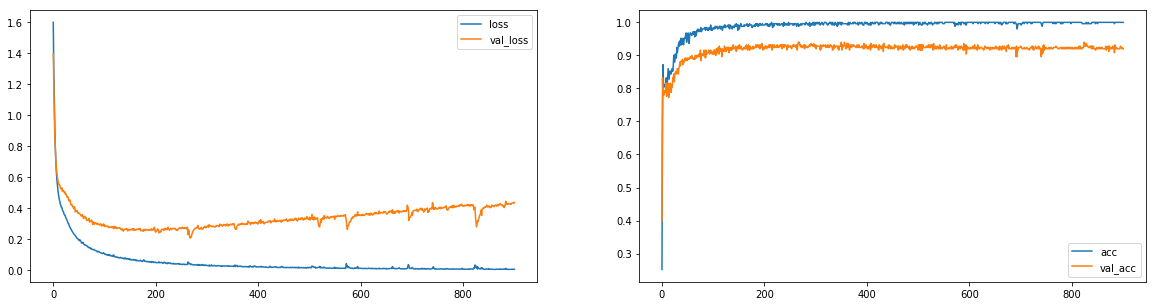

In [90]:
plot_losses = PlotLosses(plot_interval=100, 
                         evaluate_interval=None, 
                         x_val=X_test, 
                         y_val_categorical=y_test_cat)
model_sm_nn.fit(X_train, 
          y_train_cat, 
          batch_size = batch_size,
          epochs=epochs, 
          verbose=0, 
          validation_data=(X_test, y_test_cat), 
          callbacks=[plot_losses],
         )

88960/90000 [============================>.] - ETA: 0s

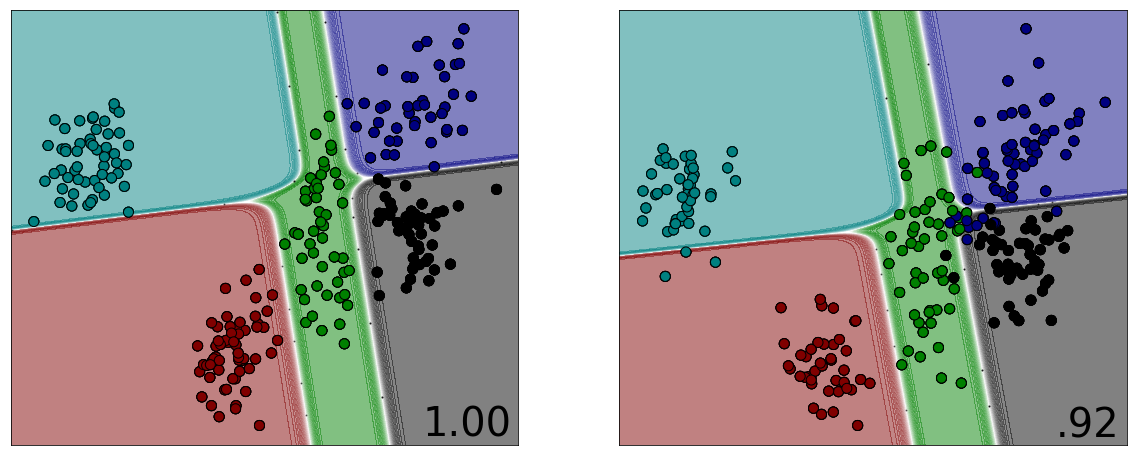

In [91]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
score_train = model_sm_nn.evaluate(X_train, y_train_cat)
score_test = model_sm_nn.evaluate(X_test, y_test_cat)
MH.plot_MC_boundaries_keras(X_train, y_train, score_train[1], model_sm_nn.predict_proba, h =.05, ax=ax1)
MH.plot_MC_boundaries_keras(X_test, y_test, score_test[1], model_sm_nn.predict_proba, h =.05, ax=ax2)
plt.show()

softmax cross-entropy:  
http://peterroelants.github.io/posts/neural_network_implementation_intermezzo02/